# **MÔ HÌNH DỰ ĐOÁN CẢM XÚC VĂN BẢN - TIẾNG VIỆT**



## Cài đặt thư viện


In [ ]:
!pip install pandas==2.2.2
!pip install seaborn==0.13.2
!pip install matplotlib
!pip install nltk==3.8.1
!pip install scikit-learn==1.5.1
!pip install pyvi

## Nhập thư viện
### Các thư viện sử dụng trong mô hình
   1. **pandas**: Phân tích bộ dữ liệu

   2. **seaborn, matplotlib**:  Trực quan hóa dữ liệu

   3. **time**: Tính thời gian huấn luyện của mô hình

   4. **re, nltk, pyvi**: Tiền xử lý dữ liệu văn bản

   5. **sklearn TfidfVectorizer**: Vector hóa dữ liệu văn bản

   6. **sklearn train_test_split**: Phân chia bộ dữ liệu để huấn luyện và kiểm tra

   7. **sklearn LogisticRegression, MultinomialNB**: Xây dựng mô hình LogisticRegression và Naive Bayes
   
   8. **sklearn accuracy_score, classification_report, confusion_matrix**: Đánh giá hiệu quả mô hình


In [9]:
#import lib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import re
from pyvi import ViTokenizer

## Đọc tệp dữ liệu csv bằng thư viện pandas
Bộ dữ liệu được nhóm lấy trên Kaggle tại [đây](https://www.kaggle.com/datasets/linhlpv/vietnamese-sentiment-analyst)

In [10]:
vietnamese_dataset = "vietnamese_dataset.csv"
data = pd.read_csv(vietnamese_dataset)

## Xem qua về bộ dữ liệu
 Đánh giá cơ bản đây bộ dữ liệu này không nhiều (**31.460** đánh giá) như bộ dữ liệu về đánh giá phim ở trên (50.000 đánh giá). Hơn nữa, các đánh giá ngoài được đánh nhãn **tích cực (POS)** hoặc **tiêu cực (NEG)** thì ở bộ dữ liệu này còn có thêm nhãn **trung lập (NEU)**.

In [11]:
data

,review,sentiment,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN
...,...,...,...,...
31455,Không đáng tiền.,NEG,1,NaN
31456,Quần rất đẹp.,POS,5,NaN
31457,Hàng đẹp đúng giá tiền.,POS,5,NaN
31458,Chất vải khá ổn.,POS,4,NaN


## Phân tích bộ dữ liệu


 Ở bộ dữ liệu thừa một cột ở cuối **không** có dữ liệu và có thêm một cột **rate** gồm các giá trị nguyên từ **1** đến **5**, thể hiện **mức độ** cảm xúc. 

 Tuy nhiên, ở mô hình chúng ta triển khai sẽ không sử dụng cột này do chỉ cần dự đoán được cảm xúc là được. Do đó, ta sẽ **loại bỏ** đi 2 cột cuối.

In [12]:
data=data[["review","sentiment"]]
data

,review,sentiment
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS
...,...,...
31455,Không đáng tiền.,NEG
31456,Quần rất đẹp.,POS
31457,Hàng đẹp đúng giá tiền.,POS
31458,Chất vải khá ổn.,POS


In [13]:
data.shape

(31460, 2)

In [14]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     31460 non-null  object
 1   sentiment  31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


 Bộ dữ liệu **không có** sample nào bị đánh nhãn thiếu.

In [16]:
missing_values=data.isnull().sum() # missing values

percent_missing = data.isnull().sum()/data.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %
review,0,0.0
sentiment,0,0.0


Tuy nhiên, số lượng các đánh giá tích cực chiếm tới **63.9%** số lượng dữ liệu và chỉ có **21.2%** là đánh giá tiêu cực và **14.9%** đánh giá trung lập.

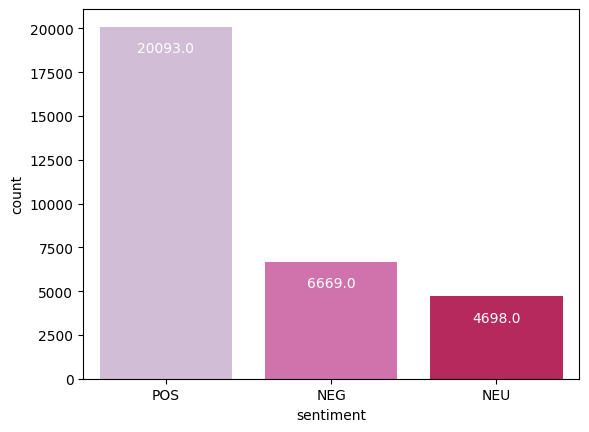

In [17]:
ax = sns.countplot(x='sentiment',data=data, palette="PuRd")
for p in ax.patches:
     ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+100), ha='center', va='top', color='white', size=10)
plt.show()

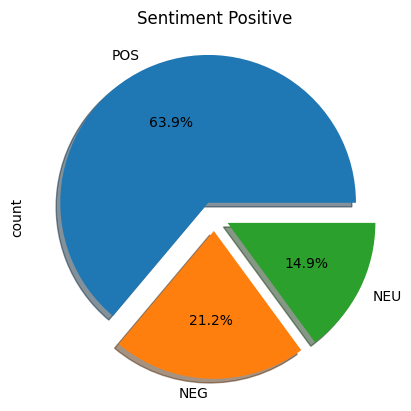

In [18]:
data["sentiment"].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',shadow=True)
plt.title('Sentiment Positive');

## Phân chia bộ dữ liệu
Bộ dữ liệu được chia thành **2** phần: **Huấn luyện (train)** và **Kiểm thử (test)** với tỷ lệ **80%:20%**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)

## Tiền xử lý dữ liệu
### Các bước xử lý
   1. Chuyển ký tự viết **hoa** về viết **thường**

   2. Xóa các **dấu câu**, **ký tự đặc biệt**

   3. Xóa các từ nối, liên từ,...

   4. Chuyển các từ về **cơ bản** bằng hàm **ViTokenizer.tokenize()** từ thư viện **pyvi**

   5. Áp dụng **hàm tiền xử lý** vào tập **train** và **test**


In [20]:
def pre_process(text):
    #Chuyển ký tự viết thường
    text = text.lower()
    #Xóa ký tự dấu câu và đặc biệt
    text = re.sub(r'[^\w\s!]', '', text)
    stop_words = set([
    'của', 'là', 'và', 'có', 'để', 'với', 'theo', 'như', 'bởi', 'đã'])
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    text = ViTokenizer.tokenize(text)
    return text

x_train = x_train.apply(pre_process)
x_test = x_test.apply(pre_process)

## Vector hóa dữ liệu

 Sử dụng phương pháp **TF-IDF Vectorization** để chuyển các dữ liệu dạng **văn bản** về dạng **vector**

In [21]:
vectorizer = TfidfVectorizer(max_features=5000)

x_train_tfidf = vectorizer.fit_transform(x_train)

x_test_tfidf = vectorizer.transform(x_test)

## Xây dựng hàm đánh giá hiệu quả mô hình
 Khởi tạo các biến **từ điển (dictionary)** để lưu giá trị **độ chính xác** và **thời gian** huấn luyện mô hình

In [22]:
accuracies = {}
algo_time={}

### Các chức năng của hàm 
   1. In ra chỉ số **Accuracy**

   2. In ra các chỉ số **Recall, Precision, F1-Score**

   3. In ra **ConFusion Matrix**

In [23]:
def print_performance(yt,clf,clf_name):
    y_pred=clf.predict(x_test_tfidf)
    accuracies[clf_name]=accuracy_score(y_test, y_pred)*100
    print("\nAccuracy Score :",accuracies[clf_name],"%")
    print('\nClassification Report : ','\n',classification_report(yt,y_pred))

    confusionmatrix=confusion_matrix(yt,y_pred)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confusionmatrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusionmatrix.shape[0]):
        for j in range(confusionmatrix.shape[1]):
            ax.text(x=j, y=i,s=confusionmatrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)

## Mô hình **Logistic Regression**

Nhắc lại một chút kiến thức về mô hình **Logistic Regression (LR)** đã học trong khóa **AI Adventure**, mô hình **LR** nhận đầu vào là các biến vector $x = [x_1, x_2,...,x_n]$ với đầu ra thường là biến nhị phân là **0** hoặc **1** (Tuy nhiên bằng việc kết hợp các mô hình LR nhị phân thì đầu ra có thể nhận nhiều hơn 2 giá trị). Cụ thể, từ việc huấn luận, mô hình sẽ cho ra hàm tuyến tính:
$$
     z = w^{T}x = w_0+w_{1}x_{1}+w_{2}x_{2}+...+w_{n}x_{n}
$$
Ở đây, vector $w$ là vector chứa các trọng số thu được từ việc huấn luyện. Khi sử dụng mô hình, đầu vào của người dùng được chuyển thành vector **n** chiều là $x$ và được đưa vào hàm **sigmoid**
$$
    \sigma(z) = \frac{1}{1+e^{-z}}=\frac{1}{1+e^{-w^{T}x}}
$$
Đặc điểm của hàm **sigmoid** là nó bị chặn trong khoảng $(0,1)$ và $ \lim_{x \to -\infty} \sigma(x) =0$ và $ \lim_{x \to +\infty} \sigma(x) =1$, hơn nữa đạo hàm của hàm này đơn giản nên được sử dụng rộng rãi. Tùy vào từng loại bài toán mà giá trị của hàm **sigmoid** vượt ngưỡng (thường là 0.5) sẽ đầu ra là 1 và bằng 0 nếu ngược lại.

Trong mã nguồn của dự án, ta sẽ chỉ cần gọi thư viện **scikit-learn** và cho tập huấn luyện đã xử lý vào hàm **LogisticRegression()** là sẽ thu được mô hình.

LOGISTIC REGRESSION

Accuracy Score : 77.51112523839797 %

Classification Report :  
               precision    recall  f1-score   support

         NEG       0.68      0.74      0.71      1333
         NEU       0.47      0.20      0.28       978
         POS       0.84      0.93      0.88      3981

    accuracy                           0.78      6292
   macro avg       0.66      0.62      0.62      6292
weighted avg       0.74      0.78      0.75      6292



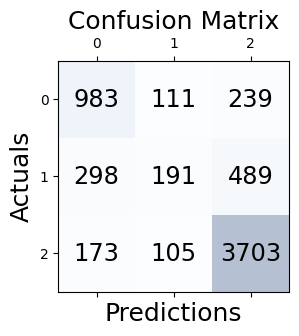

In [24]:
print("LOGISTIC REGRESSION")
start = time.time()
model_LR = LogisticRegression()
model_LR.fit(x_train_tfidf, y_train)
end = time.time()
print_performance(y_test,model_LR,'LOGISTIC REGRESSION')
algo_time['LOGISTIC REGRESSION']=end-start

## Mô hình **Naive Bayes**
Đây là mô hình dựa trên **định lý Bayes** với giả định **ngây thơ (naive)** rằng các đặc trưng là **độc lập** với nhau trong mỗi lớp, vì trong hầu hết bài toán thì chúng luôn có liên quan đến nhau. Đầu vào của mô hình là vector **n** chiều $x$, mô hình sẽ phân loại $x$ vào một trong $C$ nhãn cho trước, bằng cách tính xác suất $x$ rơi vào nhãn nào là lớn nhất. Tức là $x$ được gán nhãn $c$ nếu:
$$
     \displaystyle c = \underset{c \in \{1, \ldots, C\}}{\arg\max} \; p(c \mid x) 
$$
\indent Theo **định lý Bayes** và việc $p(x)$ **không** phụ thuộc vào $c$ ta viết lại thành:
$$
     \displaystyle c = \underset{c}{\arg\max} \; p(c \mid x) = \underset{c}{\arg\max} \; \frac{p(x \mid c)p(c)}{p(x)} = \underset{c}{\arg\max} \; {p(x \mid c)p(c)}
$$
\indent Giá trị của $p(c)$ được tính bằng tỷ lệ của dữ liệu nhãn $c$ trong toàn bộ tập huấn luyện, còn $p(x \mid c$ theo giả định **naive** của ta thì cho bởi:
$$
     p(x|c) = p(x_{1},...,x_{n}|c)= \displaystyle \prod_{i=1}^n p(x_i|c)
$$
Cả hai giá trị này được xác định khi huấn luyện. Trên đây là những ý cơ bản của **Naive Bayes**, tuy giả định **naive** có phần ngây ngô nhưng lại mang đến kết quả khá khả quan trong nhiều bài toán học máy. Trong dự án này, ta cũng chỉ cần gọi hàm **MultinomialNB()** vào tập huấn luyện là hoàn thiện mô hình này.

NAIVE BAYES

Accuracy Score : 74.26891290527654 %

Classification Report :  
               precision    recall  f1-score   support

         NEG       0.64      0.64      0.64      1333
         NEU       0.48      0.06      0.11       978
         POS       0.78      0.95      0.85      3981

    accuracy                           0.74      6292
   macro avg       0.63      0.55      0.53      6292
weighted avg       0.70      0.74      0.69      6292



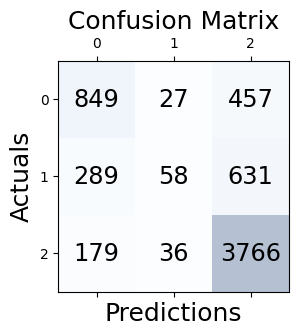

In [25]:
print("NAIVE BAYES")
start = time.time()
model_NB =  MultinomialNB()
model_NB.fit(x_train_tfidf, y_train)
end = time.time()
print_performance(y_test,model_NB,"NAIVE BAYES")
algo_time["NAIVE BAYES"]=end-start

## So sánh kết quả của 2 mô hình **Logistic Regresstion** và **Naive Bayes**

Để ý rằng hiệu quả của mỗi mô hình sẽ được tính bằng chỉ số **accuracy**, tức là tỷ số các **dự đoán đúng** trên **tổng số dự đoán**, do vai trò của mỗi nhãn tiêu cực, tích cực hay trung lập là như nhau.

Kết quả vẫn nghiên về mô hình **LR** với tỷ lệ dự đoán đúng là **77.51%** ở mức có thể chấp nhận và đã được dự tính từ trước.

In [26]:
import plotly.express as px
fig = px.bar(x=list(accuracies.keys()), y=list(accuracies.values()))
fig.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig.update_layout(title="Accuracy Comparision", xaxis_title="Model", yaxis_title="Accuracy")
fig.show()

In [27]:
fig = px.bar(x=list(algo_time.keys()), y=list(algo_time.values()))
fig.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig.update_layout(title="Algorithm Time Comparision", xaxis_title="Model", yaxis_title="")
fig.show()

## Kiểm thử mô hình với các đánh giá mới

### Hàm lấy đánh giá và dự đoán

In [28]:
def predict_rating(review):
    review_tfidf = vectorizer.transform([review])
    predicted_rating = model_LR.predict(review_tfidf)
    return predicted_rating

### Nhập đánh giá mới

In [29]:
new_review = input("Enter your review: ")
predicted_rating = predict_rating(new_review)
print("Predicted rating:", predicted_rating)

Predicted rating: ['POS']
